## Introduction

This notebook demonstrates how to load 
[US Census American Community Survey (ACS) 5-year data](https://www.census.gov/data/developers/data-sets/acs-5year.html)
and do demographic analysis on it. The process is very much parallel to how we loaded and used
[US Census redistricting data](https://www.census.gov/programs-surveys/decennial-census/about/rdo.html)
in the 
[SoMa DIS Demo](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb)
and 
[Seeing White](https://github.com/vengroff/censusdis/blob/main/notebooks/Seeing%20White.ipynb)
notebooks.

## Imports and configuration

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.states
from censusdis.maps import ShapeReader, clip_to_states

import divintseg as dis

In [3]:
# Set your API key here.
CENSUS_API_KEY = None

In [4]:
SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

# Make sure it is there.
if not os.path.isdir(SHAPEFILE_ROOT):
    os.mkdir(SHAPEFILE_ROOT)

ced.set_shapefile_path(SHAPEFILE_ROOT)

In [5]:
YEAR = 2019
DATASET = "acs/acs5"

In [6]:
# Feel free to try other states.
STATE = censusdis.states.STATE_NJ

## Make a metadata call to find out what fields are available

The group we chose is [B03002](https://api.census.gov/data/2019/acs/acs1/groups/B03002.html), 
which has race and ethnicity estimates down to the census block group level.

In [7]:
GROUP = "B03002"

In [8]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

## Load the data and compute diversity and integration

In [9]:
df_acs5 = ced.download_detail(
    DATASET,
    YEAR,
    leaves,
    state=STATE,
    block_group="*",
    api_key=CENSUS_API_KEY,
)

In [10]:
df_di = dis.di(
    df_acs5,
    by="TRACT",
    over="BLOCK_GROUP",
)

df_di.describe()

,diversity,integration
count,1611.000000,1611.000000
mean,0.479671,0.455679
std,0.207469,0.194701
min,0.000000,0.000000
25%,0.309495,0.297333
50%,0.502399,0.475027
75%,0.666197,0.624464
max,0.846843,0.820712


## Load map data and merge in our diversity and integration data

In [11]:
reader = ShapeReader(SHAPEFILE_ROOT, year=YEAR)

In [12]:
gdf_tracts = reader.read_shapefile(STATE, "tract")

In [13]:
gdf_di = gdf_tracts.merge(df_di, left_on="TRACTCE", right_on="TRACT")[
    ["STATEFP", "TRACTCE", "diversity", "integration", "geometry"]
]

## Clip to the state boundaries

This is important because some of the tracts extend out into water in ways that produces
artifacts in maps. Comment out the line `gdf_di = clip_to_states(gdf_di, gdf_state)` and
rerun the notebook if you want to see the difference.

In [14]:
# gdf_state = reader.read_state_bounds_shapefile(STATE)
gdf_state = reader.read_cb_shapefile("us", "state")

In [15]:
gdf_di = clip_to_states(gdf_di, gdf_state)

/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


## Plot the data for the state

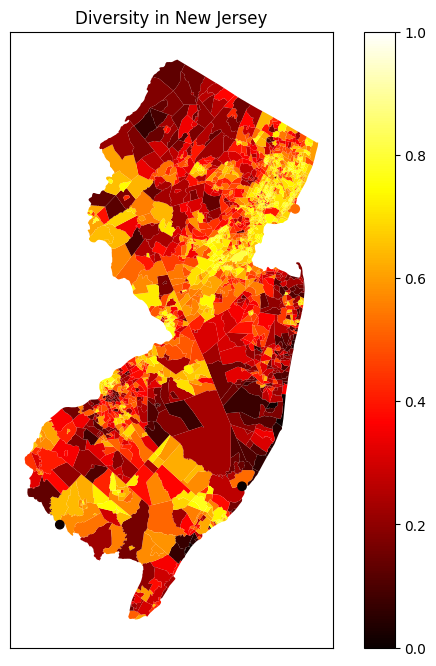

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)

ax = gdf_di.plot(
    "diversity",
    cmap="hot",
    # edgecolor="black",
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title(f"Diversity in {censusdis.states.STATE_NAMES_FROM_IDS[STATE]}")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)